# Heart Failure 

In [18]:
# 필요한 모듈 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 데이터 불러오기

In [19]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
clean_df = pd.read_csv('heart_failure_clean.csv')
clean_df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,High_blood_pressure,ct_gr
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1,1,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1,0,0
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1,0,0
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1,0,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1,0,1


### EDA

[Text(0, 0, '203'), Text(0, 0, '96')]

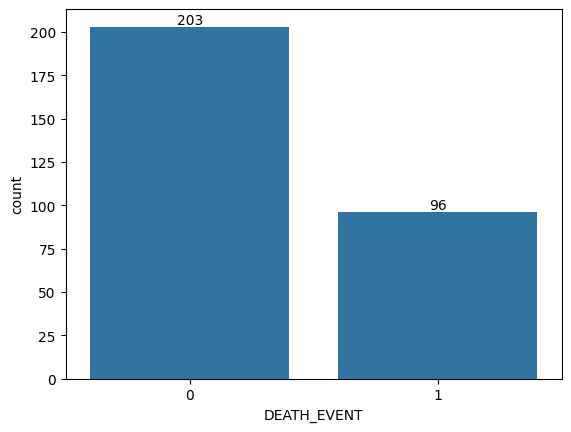

In [20]:
#클래스 불균형 확인
ax = sns.countplot(x= df["DEATH_EVENT"])
ax.bar_label(ax.containers[0])

<Axes: >

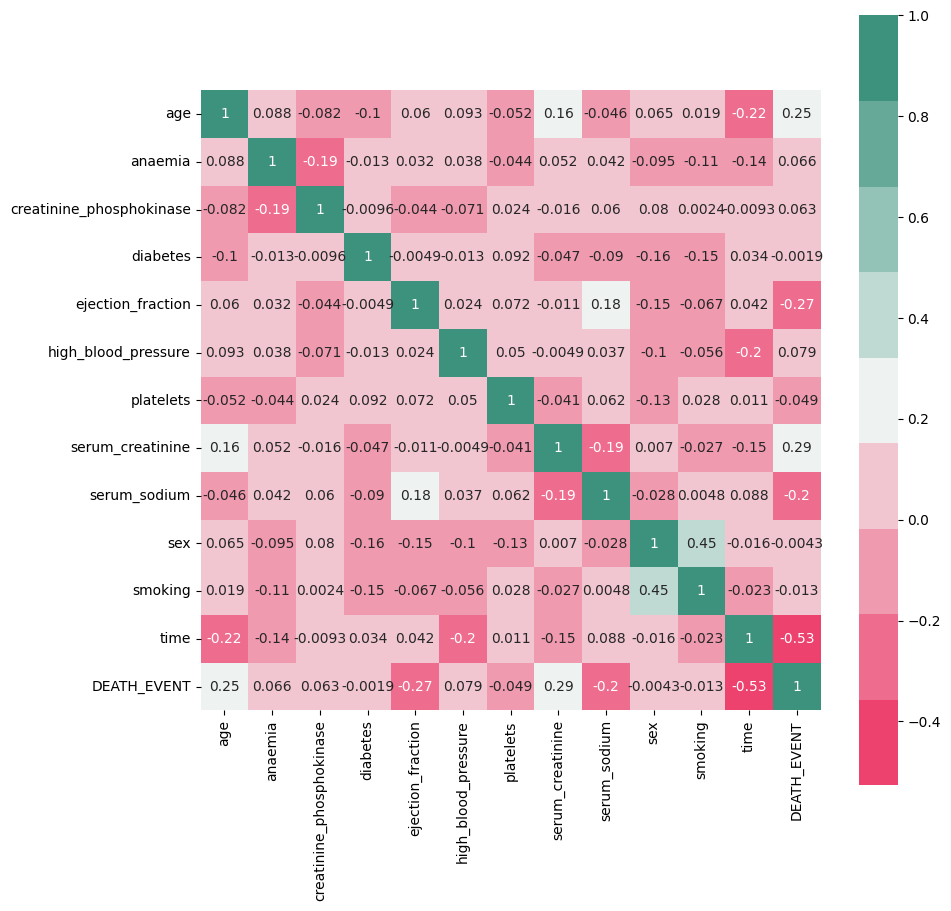

In [21]:
 # 상관계수 행렬
cmap = sns.diverging_palette(2,165,s=80,l=55,n=9)
corrmat = df.corr()
plt.subplots(figsize=(10,10))
sns.heatmap(corrmat, cmap=cmap, annot=True, square=True)

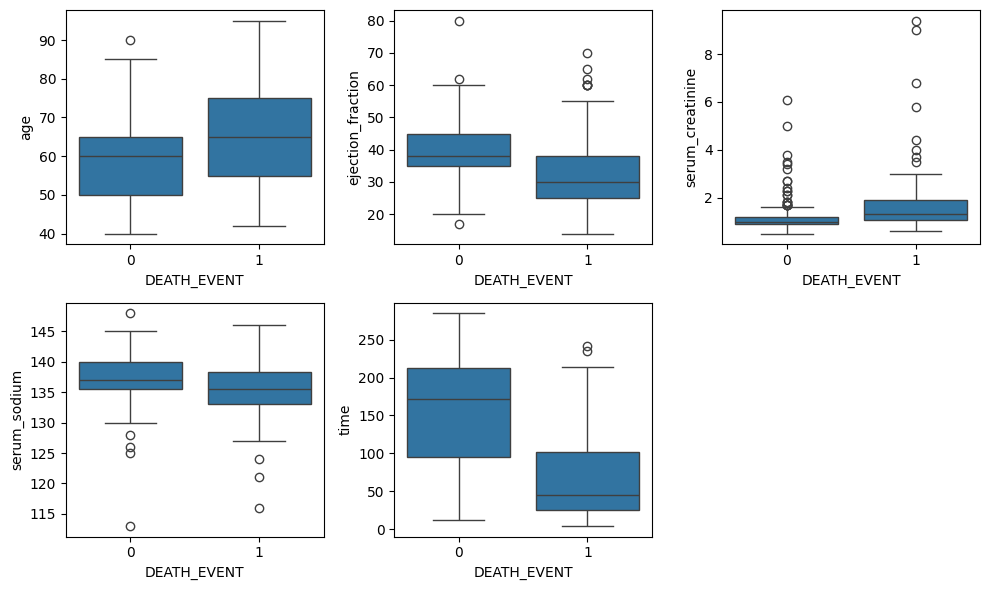

In [15]:
#데이터 시각화 및 이상치 확인
plt.figure(figsize=(10, 6))

plt.subplot(2, 3, 1)
sns.boxplot(x="DEATH_EVENT", y="age", data=df)

plt.subplot(2, 3, 2)
sns.boxplot(x="DEATH_EVENT", y="ejection_fraction", data=df)

plt.subplot(2, 3, 3)
sns.boxplot(x="DEATH_EVENT", y="serum_creatinine", data=df)

plt.subplot(2, 3, 4)
sns.boxplot(x="DEATH_EVENT", y="serum_sodium", data=df)

plt.subplot(2, 3, 5)
sns.boxplot(x="DEATH_EVENT", y="time", data=df)

plt.tight_layout() 
plt.show()

In [16]:
# 이상치 개수 확인 (IQR 기준)
def find_outliers_iqr(data_column):
    quartile_1, quartile_3 = np.percentile(data_column, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - 1.5 * iqr
    upper_bound = quartile_3 + 1.5 * iqr
    outliers = np.where((data_column < lower_bound) | (data_column > upper_bound))[0]
    return outliers
def count_outliers_iqr(data):
    outlier_count = 0
    for column in data.columns:
        outliers = find_outliers_iqr(data[column])
        outlier_count += len(outliers)
        print(f"IQR 이상치 ({column}): {len(outliers)} 개")
    print(f"총 이상치 개수: {outlier_count} 개")
count_outliers_iqr(clean_df)

IQR 이상치 (age): 0 개
IQR 이상치 (anaemia): 0 개
IQR 이상치 (creatinine_phosphokinase): 29 개
IQR 이상치 (diabetes): 0 개
IQR 이상치 (ejection_fraction): 2 개
IQR 이상치 (high_blood_pressure): 0 개
IQR 이상치 (platelets): 21 개
IQR 이상치 (serum_creatinine): 29 개
IQR 이상치 (serum_sodium): 4 개
IQR 이상치 (sex): 0 개
IQR 이상치 (smoking): 0 개
IQR 이상치 (time): 0 개
IQR 이상치 (DEATH_EVENT): 0 개
IQR 이상치 (High_blood_pressure): 0 개
IQR 이상치 (ct_gr): 72 개
총 이상치 개수: 157 개


In [17]:
#변수 선택
use_df = clean_df[['age','ejection_fraction','serum_sodium','time','ct_gr','DEATH_EVENT']]
use_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                299 non-null    float64
 1   ejection_fraction  299 non-null    int64  
 2   serum_sodium       299 non-null    int64  
 3   time               299 non-null    int64  
 4   ct_gr              299 non-null    int64  
 5   DEATH_EVENT        299 non-null    int64  
dtypes: float64(1), int64(5)
memory usage: 14.1 KB


### 학습/테스트 데이터 분리

In [35]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

In [36]:
X = use_df.drop(["DEATH_EVENT"],axis=1)
y = use_df['DEATH_EVENT']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

### SMOTE

Text(0.5, 1.0, 'Synthetic Examples Generated Using SMOTE')

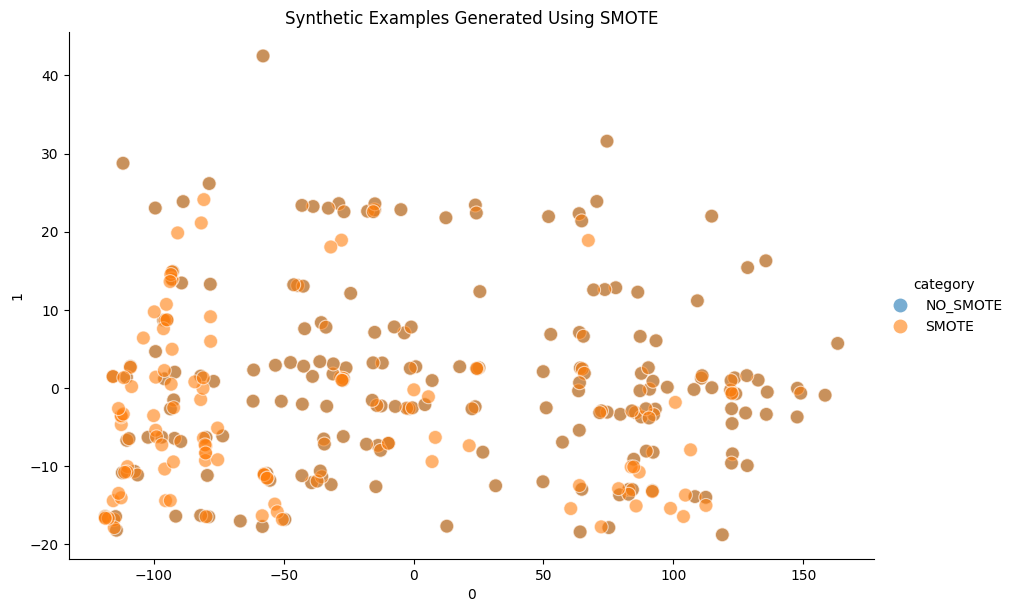

In [37]:
# 1. SMOTE 적용 (여기까지는 숫자 데이터만 있어야 함)
smote = SMOTE(random_state=42)
X_train = X_train.select_dtypes(include=["number"])
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

X_train["category"] = "NO_SMOTE"
X_train_smote["category"] = "SMOTE"

final_X = pd.concat([X_train, X_train_smote], axis=0).copy()

final_cat = final_X["category"]
final_X.drop(columns="category",inplace=True)
pca = PCA(n_components=2)
final_X = pd.DataFrame(pca.fit_transform(final_X))
final_X["category"] = list(final_cat)
final_X = final_X.loc[(final_X[0]<=200000) & (final_X[1]<=2000),:].copy()
sns.relplot(data=final_X,x=0,y=1,hue="category",alpha=0.6,s=100,height=6,aspect=1.5)
plt.title("Synthetic Examples Generated Using SMOTE")


In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

In [41]:
selected_features = ['age', 'ejection_fraction', 'serum_sodium', 'time', 'ct_gr']
 
X_new = clean_df[selected_features].copy()
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)
 
smote = SMOTE(random_state=42) 
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Random Forest

In [42]:
model_rf = RandomForestClassifier(random_state=42)
 
gscv_rf = GridSearchCV(estimator=model_rf,param_grid={
    "n_estimators":[100,1000],
    "criterion":["gini","entropy"],
    "max_depth":[3,5],
    "min_samples_split":[8,10],
    "min_samples_leaf":[10,20],
 },cv=cv,n_jobs=-1,scoring="accuracy")
 
gscv_rf.fit(X_train_smote, y_train_smote)
 
MODEL_RF = gscv_rf.best_estimator_
MODEL_RF.score(X_train_smote,y_train_smote)

0.9066666666666666

In [43]:
MODEL_RF

RandomForestClassifier(max_depth=5, min_samples_leaf=10, min_samples_split=8,
                       random_state=42)

In [44]:
train_pred_rf = MODEL_RF.predict(X_train_smote)
print(classification_report(y_train_smote,train_pred_rf))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       150
           1       0.91      0.90      0.91       150

    accuracy                           0.91       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.91      0.91      0.91       300



### Dicision Tree

In [45]:
 from sklearn.tree import DecisionTreeClassifier

In [47]:
model_dt= DecisionTreeClassifier(random_state=42)
 
gscv_dt = GridSearchCV(estimator=model_dt, param_grid={
    "criterion": ["gini", "entropy"],
    "max_depth": [3, 5, 10],
    "min_samples_split": [80,100],
    "min_samples_leaf": [20, 30],
 }, cv=cv, n_jobs=-1, scoring="accuracy")
 
gscv_dt.fit(X_train_smote, y_train_smote)
 
MODEL_DT = gscv_dt.best_estimator_
MODEL_DT.score(X_train_smote, y_train_smote)

0.8566666666666667

In [48]:
MODEL_DT

DecisionTreeClassifier(max_depth=3, min_samples_leaf=20, min_samples_split=80,
                       random_state=42)

In [49]:
train_pred_dt = MODEL_DT.predict(X_train_smote)
print(classification_report(y_train_smote,train_pred_dt))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86       150
           1       0.85      0.87      0.86       150

    accuracy                           0.86       300
   macro avg       0.86      0.86      0.86       300
weighted avg       0.86      0.86      0.86       300



### SVM

In [51]:
from sklearn.svm import SVC

In [52]:
model_svm = SVC(probability=True,random_state=42)
 
gscv_svm = GridSearchCV(estimator=model_svm, param_grid={
    'C': [1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
 }, cv=cv, n_jobs=-1, scoring="f1_weighted")
 
gscv_svm.fit(X_train_smote, y_train_smote)
 
MODEL_SVM = gscv_svm.best_estimator_
MODEL_SVM.score(X_train_smote, y_train_smote)


0.83

In [53]:
MODEL_SVM

SVC(C=1, probability=True, random_state=42)

In [54]:
train_pred_svm = MODEL_SVM.predict(X_train_smote)
print(classification_report(y_train_smote,train_pred_svm))

              precision    recall  f1-score   support

           0       0.77      0.93      0.85       150
           1       0.92      0.73      0.81       150

    accuracy                           0.83       300
   macro avg       0.84      0.83      0.83       300
weighted avg       0.84      0.83      0.83       300



### LogistiRegreesion

In [55]:
from sklearn.linear_model import LogisticRegression

In [56]:
model_logreg = LogisticRegression(random_state=42)
 
gscv_logreg = GridSearchCV(estimator=model_logreg, param_grid={
    'C': [0.1, 1, 10, 100],
    'penalty': ['l2'],
 }, cv=cv, n_jobs=-1, scoring="accuracy")
 
gscv_logreg.fit(X_train_smote, y_train_smote)
 
MODEL_LOGREG = gscv_logreg.best_estimator_
MODEL_LOGREG.score(X_train_smote, y_train_smote)

0.8133333333333334

In [57]:
MODEL_LOGREG

LogisticRegression(C=10, random_state=42)

In [58]:
train_pred_lg = MODEL_LOGREG.predict(X_train_smote)
print(classification_report(y_train_smote,train_pred_lg))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       150
           1       0.81      0.81      0.81       150

    accuracy                           0.81       300
   macro avg       0.81      0.81      0.81       300
weighted avg       0.81      0.81      0.81       300



### LGBM

In [59]:
from lightgbm import LGBMClassifier

ModuleNotFoundError: No module named 'lightgbm'